# CoNLL_3.ipynb

This notebook contains the second part of the model training and analysis code from our CoNLL-2020 paper, ["Identifying Incorrect Labels in the CoNLL-2003 Corpus"](https://www.aclweb.org/anthology/2020.conll-1.16/).

If you're new to the Text Extensions for Pandas library, we recommend that you start
by reading through the notebook [`Analyze_Model_Outputs.ipynb`](https://github.com/CODAIT/text-extensions-for-pandas/blob/master/notebooks/Analyze_Model_Outputs.ipynb), which explains the 
portions of the library that we use in the notebooks in this directory.

### Summary

This notebook computes BERT embeddings at every token position in the CoNLL-2003 corus. Then it uses the "train" fold of the corpus to train an ensemble of 17 different models over the embeddings. Next, it evaluates the models over all three folds of the corpus, then uses the same aggregation techniques used in `CoNLL_2.ipynb` to flag potentially-incorrect labels. Finally, it writes out CSV files containing ranked lists of potentially-incorrect labels.


# Imports and constants

In [1]:
# Libraries

# Prevent BLAS routines from using unnecessary numbers of cores.
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"

os.environ["TOKENIZERS_PARALLELISM"] = "False"

import gc
import sys
import numpy as np
import pandas as pd
import pickle 
import time
import torch
import transformers
from typing import *

import sklearn.pipeline
import multiprocessing

import matplotlib.pyplot as plt
import ipywidgets
from IPython.display import display

try:
    import text_extensions_for_pandas as tp
except ModuleNotFoundError as e:
    raise Exception("text_extensions_for_pandas package not found on the Jupyter "
                    "kernel's path. Please either run:\n"
                    "   ln -s ../../text_extensions_for_pandas .\n"
                    "from the directory containing this notebook, or use a Python "
                    "environment on which you have used `pip` to install the package.")

import text_extensions_for_pandas.cleaning as cleaning


# Use hardware acceleration if present.
if torch.backends.mps.is_available():
    torch.set_default_device("mps")
elif torch.backends.cuda.is_available():
    torch.set_default_device("cuda")


# How many iterations to run the BFGS optimizer when fitting logistic
# regression models. 100 ==> Fast; 10000 ==> Full convergence
LBFGS_ITERATIONS = 10000

# BERT Configuration
#bert_model_name = "bert-base-uncased"
#bert_model_name = "bert-large-uncased"
bert_model_name = "dslim/bert-base-NER"

tokenizer = transformers.BertTokenizerFast.from_pretrained(bert_model_name)
# Disable the warning about long sequences. We know what we're doing.
# Different versions of transformers disable this warning differently,
# so we need to do this twice.
tokenizer.deprecation_warnings[
    "sequence-length-is-longer-than-the-specified-maximum"] = True
tokenizer.model_max_length = 16384

bert = transformers.BertModel.from_pretrained(bert_model_name)

# Create a Pandas categorical type for consistent encoding of categories
# across all documents.
_ENTITY_TYPES = ["LOC", "MISC", "ORG", "PER"]
token_class_dtype, int_to_label, label_to_int = tp.io.conll.make_iob_tag_categories(_ENTITY_TYPES)

In [2]:
# Download and cache the data set.
# NOTE: This data set is licensed for research use only. Be sure to adhere
#  to the terms of the license when using this data set!
data_set_info = tp.io.conll.maybe_download_conll_data("outputs")
data_set_info

{'train': 'outputs/eng.train',
 'dev': 'outputs/eng.testa',
 'test': 'outputs/eng.testb'}

# Retokenize with a BERT tokenizer.

Retokenize the corpus using a "BERT-compatible" tokenizer, and map the token/entity labels from the original corpus on to the new tokenization.

In [3]:
# Read in the corpus in its original tokenization
def read_corpus():
    corpus = {}
    for fold_name, file_name in data_set_info.items():
        df_list = tp.io.conll.conll_2003_to_dataframes(
            file_name, ["pos", "phrase", "ent"], [False, True, True])
        corpus[fold_name] = [
            df.drop(columns=["pos", "phrase_iob", "phrase_type"])
            for df in df_list
        ]
    return corpus
        
corpus_raw = read_corpus()

test_raw = corpus_raw["test"]

# Pick out the dataframe for a single example document.
example_df = test_raw[5]
example_df

,span,ent_iob,ent_type,sentence,line_num
0,"[0, 10): '-DOCSTART-'",O,None,"[0, 10): '-DOCSTART-'",1469
1,"[11, 18): 'CRICKET'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1471
2,"[18, 19): '-'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1472
3,"[20, 28): 'PAKISTAN'",B,LOC,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1473
4,"[29, 30): 'V'",O,None,"[11, 62): 'CRICKET- PAKISTAN V NEW ZEALAND ONE...",1474
...,...,...,...,...,...
350,"[1620, 1621): '8'",O,None,"[1590, 1634): 'Third one-day match: December 8...",1865
351,"[1621, 1622): ','",O,None,"[1590, 1634): 'Third one-day match: December 8...",1866
352,"[1623, 1625): 'in'",O,None,"[1590, 1634): 'Third one-day match: December 8...",1867
353,"[1626, 1633): 'Karachi'",B,LOC,"[1590, 1634): 'Third one-day match: December 8...",1868


In [4]:
spans_df = tp.io.conll.iob_to_spans(example_df)
spans_df

,span,ent_type
0,"[20, 28): 'PAKISTAN'",LOC
1,"[31, 42): 'NEW ZEALAND'",LOC
2,"[80, 83): 'GMT'",MISC
3,"[85, 92): 'SIALKOT'",LOC
4,"[94, 102): 'Pakistan'",LOC
...,...,...
69,"[1488, 1501): 'Shahid Afridi'",PER
70,"[1512, 1523): 'Salim Malik'",PER
71,"[1535, 1545): 'Ijaz Ahmad'",PER
72,"[1565, 1573): 'Pakistan'",LOC


In [5]:
# Retokenize the document's text with the BERT tokenizer
bert_toks_df = tp.io.bert.make_bert_tokens(example_df["span"].values[0].target_text, tokenizer)
bert_toks_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask
0,0,"[0, 0): ''",101,0,1,True
1,1,"[0, 1): '-'",118,0,1,False
2,2,"[1, 2): 'D'",141,0,1,False
3,3,"[2, 4): 'OC'",9244,0,1,False
4,4,"[4, 6): 'ST'",9272,0,1,False
...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False
685,685,"[1623, 1625): 'in'",1107,0,1,False
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False
687,687,"[1633, 1634): '.'",119,0,1,False


In [6]:
# BERT tokenization includes special zero-length tokens.
bert_toks_df[bert_toks_df["special_tokens_mask"]]

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask
0,0,"[0, 0): ''",101,0,1,True
688,688,"[0, 0): ''",102,0,1,True


In [7]:
# Align the BERT tokens with the original tokenization
bert_token_spans = tp.TokenSpanArray.align_to_tokens(bert_toks_df["span"],
                                                     spans_df["span"])

pd.DataFrame({
    "original_span": spans_df["span"],
    "bert_token_span": bert_token_spans,
    "ent_type": spans_df["ent_type"]
})

,original_span,bert_token_span,ent_type
0,"[20, 28): 'PAKISTAN'","[20, 28): 'PAKISTAN'",LOC
1,"[31, 42): 'NEW ZEALAND'","[31, 42): 'NEW ZEALAND'",LOC
2,"[80, 83): 'GMT'","[80, 83): 'GMT'",MISC
3,"[85, 92): 'SIALKOT'","[85, 92): 'SIALKOT'",LOC
4,"[94, 102): 'Pakistan'","[94, 102): 'Pakistan'",LOC
...,...,...,...
69,"[1488, 1501): 'Shahid Afridi'","[1488, 1501): 'Shahid Afridi'",PER
70,"[1512, 1523): 'Salim Malik'","[1512, 1523): 'Salim Malik'",PER
71,"[1535, 1545): 'Ijaz Ahmad'","[1535, 1545): 'Ijaz Ahmad'",PER
72,"[1565, 1573): 'Pakistan'","[1565, 1573): 'Pakistan'",LOC


In [8]:
# Generate IOB2 tags and entity labels that align with the BERT tokens.
# See https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
bert_toks_df[["ent_iob", "ent_type"]] = (
    tp.io.conll.spans_to_iob(bert_token_spans, spans_df["ent_type"]))
bert_toks_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type
0,0,"[0, 0): ''",101,0,1,True,O,<NA>
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>
...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>


In [9]:
# The traditional way to transform NER to token classification is to 
# treat each combination of {I,O,B} X {entity type} as a different
# class. Generate class labels in that format.
classes_df = tp.io.conll.add_token_classes(bert_toks_df, token_class_dtype)
classes_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0
...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0


# Show how to compute embeddings

In [10]:
# Adds embeddings to our example dataframe.  Function in util.py
embeddings_df= tp.io.bert.add_embeddings(classes_df, bert)
embeddings_df

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,"[ -0.08307105, -0.35958984, 1.015068..."
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,"[ -0.22862567, -0.49313596, 1.284231..."
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,"[ 0.02847999, -0.17874229, 1.543209..."
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,"[ -0.4651755, -0.29835933, 1.07376..."
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,"[ -0.107307814, -0.33720937, 1.226980..."
...,...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0,"[ -0.12806706, -0.0023238212, 0.6781310..."
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0,"[ 0.30534145, -0.52625763, 0.8281706..."
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1,"[ -0.048739858, -0.3379733, -0.05835114..."
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0,"[ -0.005290147, -0.29743013, 0.716175..."


# Generate BERT tokens and BERT embeddings for the entire corpus

Generate BERT embeddings for every token in the entire corpus in one pass, 
and store those embeddings in a dataframe column (of type TensorType) 
alongside the tokens and labels.

In [11]:
# conll_to_bert() in tp.io.bert combines the previous few cells' operations into
# a single function.
tp.io.bert.conll_to_bert(example_df, tokenizer, bert, token_class_dtype)

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,ent_iob,ent_type,token_class,token_class_id,embedding
0,0,"[0, 0): ''",101,0,1,True,O,<NA>,O,0,"[ -0.08307105, -0.35958984, 1.015068..."
1,1,"[0, 1): '-'",118,0,1,False,O,<NA>,O,0,"[ -0.22862567, -0.49313596, 1.284231..."
2,2,"[1, 2): 'D'",141,0,1,False,O,<NA>,O,0,"[ 0.02847999, -0.17874229, 1.543209..."
3,3,"[2, 4): 'OC'",9244,0,1,False,O,<NA>,O,0,"[ -0.4651755, -0.29835933, 1.07376..."
4,4,"[4, 6): 'ST'",9272,0,1,False,O,<NA>,O,0,"[ -0.107307814, -0.33720937, 1.226980..."
...,...,...,...,...,...,...,...,...,...,...,...
684,684,"[1621, 1622): ','",117,0,1,False,O,<NA>,O,0,"[ -0.12806706, -0.0023238212, 0.6781310..."
685,685,"[1623, 1625): 'in'",1107,0,1,False,O,<NA>,O,0,"[ 0.30534145, -0.52625763, 0.8281706..."
686,686,"[1626, 1633): 'Karachi'",16237,0,1,False,B,LOC,B-LOC,1,"[ -0.048739858, -0.3379733, -0.05835114..."
687,687,"[1633, 1634): '.'",119,0,1,False,O,<NA>,O,0,"[ -0.005290147, -0.29743013, 0.716175..."


In [12]:
# Run the entire corpus through our processing pipeline.
with torch.inference_mode():  # This line cuts CPU usage by ~50%
    bert_toks_by_fold,token_class_dtype, int_to_label, label_to_int = \
        cleaning.preprocess.preprocess_documents(
            corpus_raw, "ent_type", True,
            tokenizer=tokenizer,
            bert_model=bert,
            carry_cols=['line_num'],
            iob_col='ent_iob',
            return_docs_as_dict=True)
bert_toks_by_fold["dev"][20]

preprocessing fold train


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=946, style=ProgressStyle(desc…

preprocessing fold dev


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=216, style=ProgressStyle(desc…

preprocessing fold test


IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.17669572, -0.3989963, 0.908887...",O,0
1,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",5396.0,0.0,O,<NA>,"[ -0.38553748, -0.5023272, 1.173233...",O,0
2,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",5396.0,0.0,O,<NA>,"[ -0.11718892, -0.12701061, 1.389692...",O,0
3,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",5396.0,0.0,O,<NA>,"[ -0.39025667, -0.25043315, 1.074508...",O,0
4,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",5396.0,0.0,O,<NA>,"[ -0.27732718, -0.2616016, 1.078760...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2154,2154,"[5704, 5705): ')'",114,0,1,False,"[5704, 5705): ')'",6737.0,1173.0,O,<NA>,"[ 0.015393453, -0.04064993, 1.001184...",O,0
2155,2155,"[5706, 5708): '39'",3614,0,1,False,"[5706, 5711): '39.93'",6738.0,1174.0,O,<NA>,"[ 0.07503977, 0.014401203, 1.043232...",O,0
2156,2156,"[5708, 5709): '.'",119,0,1,False,"[5706, 5711): '39.93'",6738.0,1174.0,O,<NA>,"[ -0.08579613, 0.059056036, 1.114641...",O,0
2157,2157,"[5709, 5711): '93'",5429,0,1,False,"[5706, 5711): '39.93'",6738.0,1174.0,O,<NA>,"[ 0.011378566, -0.26387298, 0.881802...",O,0


# Collate the data structures we've generated so far

In [13]:
# Create a single dataframe with the entire corpus's embeddings.
corpus_df = tp.io.conll.combine_folds(bert_toks_by_fold)
corpus_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,train,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.09850494, -0.40501904, 0.742889...",O,0
1,train,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.057021685, -0.4811214, 0.989870...",O,0
2,train,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.048243247, -0.25330064, 1.167192...",O,0
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.26682985, -0.3100883, 1.007474...",O,0
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.22296946, -0.21308465, 0.933103...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,"[1386, 1393): 'brother'",1711,0,1,False,"[1386, 1393): 'brother'",50345.0,267.0,O,<NA>,"[ -0.02817223, -0.08062269, 0.980487...",O,0
416537,test,230,315,"[1393, 1394): ','",117,0,1,False,"[1393, 1394): ','",50346.0,268.0,O,<NA>,"[ 0.1181732, -0.07008358, 0.865484...",O,0
416538,test,230,316,"[1395, 1400): 'Bobby'",5545,0,1,False,"[1395, 1400): 'Bobby'",50347.0,269.0,B,PER,"[ -0.35689452, 0.3140048, 1.573853...",B-PER,3
416539,test,230,317,"[1400, 1401): '.'",119,0,1,False,"[1400, 1401): '.'",50348.0,270.0,O,<NA>,"[ -0.18957166, -0.24581118, 0.6625743...",O,0


In [14]:
# Write the tokenized corpus with embeddings to a Feather file.
# We can't currently serialize span columns that cover multiple documents (see issue 73),
# so drop span columns from the contents we write to the Feather file.
cols_to_drop = [c for c in corpus_df.columns if "span" in c]
corpus_df.drop(columns=cols_to_drop).to_feather("outputs/corpus.feather")

In [15]:
# Write the tokenized corpus with embeddings to a Feather file.
# We can't currently serialize span columns that cover multiple documents (see issue 73),
# so drop span columns from the contents we write to the Feather file.
cols_to_drop = [c for c in corpus_df.columns if "span" in c]
corpus_df.drop(columns=cols_to_drop).to_feather("outputs/corpus.feather")

# Train an ensemble of models

Use the embeddings to quickly train multiple models at multiple levels of sophistication.

In [16]:
# Additional initialization boilerplate
import sklearn.linear_model

In [17]:
# Read the serialized embeddings back in so that you can rerun the model 
# training parts of this notebook (the cells from here onward) without 
# regenerating the embeddings.
corpus_df_after = pd.read_feather("outputs/corpus.feather")
try:
    # Verify that the embeddings came through ok
    embeddings_before = corpus_df["embedding"].values._tensor
    embeddings_after = corpus_df_after["embedding"].values._tensor
    mask = (embeddings_before == embeddings_after)
    if not np.all(mask):
        raise ValueError("Corruption of embeddings detected")
    
except NameError:
    # If we get here, `corpus_df` isn't defined, because the user ran this
    # cell without running the previous cells. That's ok. Continue on.
    #corpus_df = corpus_df_after
    # if we are not using the original model, re-add corpus spans 
    pass

corpus_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,train,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.09850494, -0.40501904, 0.742889...",O,0
1,train,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.057021685, -0.4811214, 0.989870...",O,0
2,train,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.048243247, -0.25330064, 1.167192...",O,0
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.26682985, -0.3100883, 1.007474...",O,0
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.22296946, -0.21308465, 0.933103...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,"[1386, 1393): 'brother'",1711,0,1,False,"[1386, 1393): 'brother'",50345.0,267.0,O,<NA>,"[ -0.02817223, -0.08062269, 0.980487...",O,0
416537,test,230,315,"[1393, 1394): ','",117,0,1,False,"[1393, 1394): ','",50346.0,268.0,O,<NA>,"[ 0.1181732, -0.07008358, 0.865484...",O,0
416538,test,230,316,"[1395, 1400): 'Bobby'",5545,0,1,False,"[1395, 1400): 'Bobby'",50347.0,269.0,B,PER,"[ -0.35689452, 0.3140048, 1.573853...",B-PER,3
416539,test,230,317,"[1400, 1401): '.'",119,0,1,False,"[1400, 1401): '.'",50348.0,270.0,O,<NA>,"[ -0.18957166, -0.24581118, 0.6625743...",O,0


In [18]:
train_df = corpus_df[corpus_df["fold"] == "train"]
train_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,raw_span_id,ent_iob,ent_type,embedding,token_class,token_class_id
0,train,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,NaN,O,<NA>,"[ -0.09850494, -0.40501904, 0.742889...",O,0
1,train,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.057021685, -0.4811214, 0.989870...",O,0
2,train,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.048243247, -0.25330064, 1.167192...",O,0
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.26682985, -0.3100883, 1.007474...",O,0
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,0.0,O,<NA>,"[ -0.22296946, -0.21308465, 0.933103...",O,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281104,train,945,53,"[155, 162): 'Swansea'",17057,0,1,False,"[155, 162): 'Swansea'",219549.0,25.0,B,ORG,"[ 0.7556357, -0.91891235, -0.140302...",B-ORG,1
281105,train,945,54,"[163, 164): '1'",122,0,1,False,"[163, 164): '1'",219550.0,26.0,O,<NA>,"[ -0.11528622, -0.44492117, 0.471556...",O,0
281106,train,945,55,"[165, 172): 'Lincoln'",4617,0,1,False,"[165, 172): 'Lincoln'",219551.0,27.0,B,ORG,"[ 0.4560219, -0.8970844, 0.0678623...",B-ORG,1
281107,train,945,56,"[173, 174): '2'",123,0,1,False,"[173, 174): '2'",219552.0,28.0,O,<NA>,"[ -0.19713652, -0.5427199, 0.2940205...",O,0


In [19]:
train_df["embedding"].values

array([[-0.09850494, -0.40501904,  0.7428891 , ..., -0.7416164 ,
         0.1360407 ,  0.47785777],
       [-0.05702168, -0.4811214 ,  0.9898701 , ..., -0.56108135,
         0.12308422,  0.46220663],
       [-0.04824325, -0.25330064,  1.1671928 , ..., -0.54396695,
         0.10910306,  0.50470895],
       ...,
       [ 0.4560219 , -0.8970844 ,  0.06786231, ...,  1.187176  ,
        -1.3483489 , -0.24610874],
       [-0.19713652, -0.5427199 ,  0.29402056, ..., -0.4682115 ,
         0.12332408,  0.6431015 ],
       [-0.5765073 , -0.42160615,  0.9947064 , ..., -0.6415464 ,
        -0.05481397,  0.23630753]], dtype=float32)

In [20]:
%%time

# Train a multinomial logistic regression model on the training set.
#_MULTI_CLASS = "multinomial"
base_pipeline = sklearn.pipeline.Pipeline([
    # Standard scaler. This only makes a difference for certain classes
    # of embeddings.
    #("scaler", sklearn.preprocessing.StandardScaler()),
    ("mlogreg", sklearn.linear_model.LogisticRegression(
        #multi_class=_MULTI_CLASS,
        verbose=10,
        max_iter=1000
    ))
])

X_train = train_df["embedding"].values
Y_train = train_df["token_class_id"]
base_model = base_pipeline.fit(X_train, Y_train)
base_model

CPU times: user 2min 45s, sys: 2.07 s, total: 2min 47s
Wall time: 2min 53s


[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.9min
[Parallel(n_jobs=1)]: Done   1 tasks      | elapsed:  2.9min


Pipeline(steps=[('mlogreg', LogisticRegression(max_iter=1000, verbose=10))])

In [21]:
# Look at our trained model's results on the training set
train_results_df = cleaning.infer_on_df(train_df, int_to_label, base_model,iob=True)
train_results_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,...,ent_iob,ent_type,embedding,token_class,token_class_id,predicted_id,predicted_class,predicted_iob,predicted_type,raw_output
0,train,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,...,O,<NA>,"[ -0.09850494, -0.40501904, 0.742889...",O,0,0,O,O,None,"[ 0.9989536705166111, 2.485538805754892e-0..."
1,train,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.057021685, -0.4811214, 0.989870...",O,0,0,O,O,None,"[ 0.9985403760634844, 2.1346893378092416e-0..."
2,train,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.048243247, -0.25330064, 1.167192...",O,0,0,O,O,None,"[ 0.9998209255260858, 1.823307288466641e-0..."
3,train,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.26682985, -0.3100883, 1.007474...",O,0,0,O,O,None,"[ 0.9998151852874999, 4.2583316102433407e-0..."
4,train,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.22296946, -0.21308465, 0.933103...",O,0,0,O,O,None,"[ 0.9999693587305652, 7.17667332627434e-0..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
281104,train,945,53,"[155, 162): 'Swansea'",17057,0,1,False,"[155, 162): 'Swansea'",219549.0,...,B,ORG,"[ 0.7556357, -0.91891235, -0.140302...",B-ORG,1,1,B-ORG,B,ORG,"[ 5.064120693771509e-07, 0.99994458734682..."
281105,train,945,54,"[163, 164): '1'",122,0,1,False,"[163, 164): '1'",219550.0,...,O,<NA>,"[ -0.11528622, -0.44492117, 0.471556...",O,0,0,O,O,None,"[ 0.9999979050763934, 1.1648524518993677e-1..."
281106,train,945,55,"[165, 172): 'Lincoln'",4617,0,1,False,"[165, 172): 'Lincoln'",219551.0,...,B,ORG,"[ 0.4560219, -0.8970844, 0.0678623...",B-ORG,1,1,B-ORG,B,ORG,"[ 2.910617517444319e-07, 0.999331479881933..."
281107,train,945,56,"[173, 174): '2'",123,0,1,False,"[173, 174): '2'",219552.0,...,O,<NA>,"[ -0.19713652, -0.5427199, 0.2940205...",O,0,0,O,O,None,"[ 0.9999991895627065, 7.551399244020243e-1..."


In [22]:
train_results_df.iloc[50:75]

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,...,ent_iob,ent_type,embedding,token_class,token_class_id,predicted_id,predicted_class,predicted_iob,predicted_type,raw_output
50,train,0,50,"[219, 228): 'determine'",4959,0,1,False,"[219, 228): 'determine'",37.0,...,O,<NA>,"[ -0.10121872, -0.53975147, 0.8260636...",O,0,0,O,O,None,"[ 0.9999407350442, 4.712629306221459e-0..."
51,train,0,51,"[229, 236): 'whether'",2480,0,1,False,"[229, 236): 'whether'",38.0,...,O,<NA>,"[ -0.116538055, -0.5091674, 0.8966651...",O,0,0,O,O,None,"[ 0.9999622553259838, 3.3185907583320334e-0..."
52,train,0,52,"[237, 240): 'mad'",6340,0,1,False,"[237, 240): 'mad'",39.0,...,O,<NA>,"[ -0.0041052364, -0.5452119, 0.9235701...",O,0,0,O,O,None,"[ 0.9998092211792838, 2.32684952827885e-0..."
53,train,0,53,"[241, 244): 'cow'",13991,0,1,False,"[241, 244): 'cow'",40.0,...,O,<NA>,"[ -0.072607234, -0.42375916, 0.8540787...",O,0,0,O,O,None,"[ 0.999728894545152, 1.388076305639623e-0..."
54,train,0,54,"[245, 252): 'disease'",3653,0,1,False,"[245, 252): 'disease'",41.0,...,O,<NA>,"[ -0.054863356, -0.45662877, 0.7946411...",O,0,0,O,O,None,"[ 0.9992758684450995, 1.3003892659860185e-0..."
55,train,0,55,"[253, 256): 'can'",1169,0,1,False,"[253, 256): 'can'",42.0,...,O,<NA>,"[ 0.05008141, -0.47165594, 0.8914119...",O,0,0,O,O,None,"[ 0.9998463022694668, 1.5838100895493398e-0..."
56,train,0,56,"[257, 259): 'be'",1129,0,1,False,"[257, 259): 'be'",43.0,...,O,<NA>,"[ 0.011557615, -0.5194228, 0.8665125...",O,0,0,O,O,None,"[ 0.9992407384350609, 2.0927511784441755e-0..."
57,train,0,57,"[260, 271): 'transmitted'",12086,0,1,False,"[260, 271): 'transmitted'",44.0,...,O,<NA>,"[ 0.025256604, -0.5064818, 0.9201460...",O,0,0,O,O,None,"[ 0.9998521081248065, 2.2952989727149485e-0..."
58,train,0,58,"[272, 274): 'to'",1106,0,1,False,"[272, 274): 'to'",45.0,...,O,<NA>,"[ 0.034962185, -0.45703962, 0.915990...",O,0,0,O,O,None,"[ 0.999768585674917, 1.2101156426491223e-0..."
59,train,0,59,"[275, 280): 'sheep'",8892,0,1,False,"[275, 280): 'sheep'",46.0,...,O,<NA>,"[ -0.029320655, -0.47654673, 0.820306...",O,0,0,O,O,None,"[ 0.9995825861387341, 1.7142119619933946e-0..."


In [23]:
# Look at results on the test set
test_results_df = cleaning.infer_on_df(corpus_df[corpus_df["fold"] == "test"], 
                                     int_to_label, base_model,iob=True)
test_results_df

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,...,ent_iob,ent_type,embedding,token_class,token_class_id,predicted_id,predicted_class,predicted_iob,predicted_type,raw_output
351001,test,0,0,"[0, 0): ''",101,0,1,True,NaN,NaN,...,O,<NA>,"[ -0.19626603, -0.45093778, 0.67753...",O,0,0,O,O,None,"[ 0.9995047042342696, 9.679256796785319e-0..."
351002,test,0,1,"[0, 1): '-'",118,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.31872165, -0.5074793, 1.046452...",O,0,0,O,O,None,"[ 0.9998730808257239, 9.675113459656508e-0..."
351003,test,0,2,"[1, 2): 'D'",141,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.08053864, -0.2477486, 1.356256...",O,0,0,O,O,None,"[ 0.9997619012687975, 1.841442678480761e-0..."
351004,test,0,3,"[2, 4): 'OC'",9244,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.68785805, -0.30290276, 0.884271...",O,0,0,O,O,None,"[ 0.9994259632578382, 1.0694453958636764e-0..."
351005,test,0,4,"[4, 6): 'ST'",9272,0,1,False,"[0, 10): '-DOCSTART-'",0.0,...,O,<NA>,"[ -0.29632273, -0.23313229, 0.9398829...",O,0,0,O,O,None,"[ 0.9999959808722937, 5.976389373534697e-1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416536,test,230,314,"[1386, 1393): 'brother'",1711,0,1,False,"[1386, 1393): 'brother'",50345.0,...,O,<NA>,"[ -0.02817223, -0.08062269, 0.980487...",O,0,0,O,O,None,"[ 0.9999993667863136, 3.2680707124246856e-1..."
416537,test,230,315,"[1393, 1394): ','",117,0,1,False,"[1393, 1394): ','",50346.0,...,O,<NA>,"[ 0.1181732, -0.07008358, 0.865484...",O,0,0,O,O,None,"[ 0.9999998553094595, 2.5224335785390335e-1..."
416538,test,230,316,"[1395, 1400): 'Bobby'",5545,0,1,False,"[1395, 1400): 'Bobby'",50347.0,...,B,PER,"[ -0.35689452, 0.3140048, 1.573853...",B-PER,3,3,B-PER,B,PER,"[ 3.557236921456412e-08, 6.907211478482172e-1..."
416539,test,230,317,"[1400, 1401): '.'",119,0,1,False,"[1400, 1401): '.'",50348.0,...,O,<NA>,"[ -0.18957166, -0.24581118, 0.6625743...",O,0,0,O,O,None,"[ 0.9999999741643966, 2.3441292555601724e-1..."


In [24]:
# Pick out a region with more entities
test_results_df.iloc[40:60]

,fold,doc_num,token_id,span,input_id,token_type_id,attention_mask,special_tokens_mask,raw_span,line_num,...,ent_iob,ent_type,embedding,token_class,token_class_id,predicted_id,predicted_class,predicted_iob,predicted_type,raw_output
351041,test,0,40,"[68, 70): 'di'",3309,0,1,False,"[66, 71): 'Nadim'",15.0,...,I,PER,"[ -0.21029264, -0.8535674, 0.0002740503...",I-PER,7,6,I-MISC,I,MISC,"[3.6191336911884853e-06, 3.51966425863322e-1..."
351042,test,0,41,"[70, 71): 'm'",1306,0,1,False,"[66, 71): 'Nadim'",15.0,...,I,PER,"[ -0.23205465, -0.9290747, 0.388912...",I-PER,7,6,I-MISC,I,MISC,"[ 8.816255429586186e-05, 3.2035051089108147e-0..."
351043,test,0,42,"[72, 74): 'La'",2001,0,1,False,"[72, 77): 'Ladki'",16.0,...,I,PER,"[ 0.36844227, -0.68091035, -0.10591008...",I-PER,7,8,I-LOC,I,LOC,"[ 0.0015687562258373294, 3.115764252150704e-0..."
351044,test,0,43,"[74, 75): 'd'",1181,0,1,False,"[72, 77): 'Ladki'",16.0,...,I,PER,"[ -0.3013101, -0.65459996, -0.172691...",I-PER,7,7,I-PER,I,PER,"[0.00011284067761755794, 5.548015718271205e-1..."
351045,test,0,44,"[75, 77): 'ki'",2293,0,1,False,"[72, 77): 'Ladki'",16.0,...,I,PER,"[ -0.16116077, -0.69890946, 0.2342467...",I-PER,7,8,I-LOC,I,LOC,"[ 0.01249117773105149, 5.569520511923285e-0..."
351046,test,0,45,"[78, 80): 'AL'",18589,0,1,False,"[78, 84): 'AL-AIN'",18.0,...,B,LOC,"[ -0.058566615, -0.7955875, 0.336061...",B-LOC,4,4,B-LOC,B,LOC,"[ 0.009316220345566392, 5.63829185995089e-0..."
351047,test,0,46,"[80, 81): '-'",118,0,1,False,"[78, 84): 'AL-AIN'",18.0,...,I,LOC,"[ 0.20376255, -0.73730916, -0.0888539...",I-LOC,8,8,I-LOC,I,LOC,"[ 0.27672978935217774, 3.5549991600598037e-0..."
351048,test,0,47,"[81, 83): 'AI'",19016,0,1,False,"[78, 84): 'AL-AIN'",18.0,...,I,LOC,"[ -0.10341229, -0.33681902, 0.1738470...",I-LOC,8,8,I-LOC,I,LOC,"[ 0.03943039250089963, 3.490784643165123e-0..."
351049,test,0,48,"[83, 84): 'N'",2249,0,1,False,"[78, 84): 'AL-AIN'",18.0,...,I,LOC,"[ -0.40542644, -0.65165263, 0.2469621...",I-LOC,8,8,I-LOC,I,LOC,"[ 0.0005166307195399091, 1.0439158265226732e-0..."
351050,test,0,49,"[84, 85): ','",117,0,1,False,"[84, 85): ','",19.0,...,O,<NA>,"[ -0.16829303, -0.6475871, 0.814902...",O,0,0,O,O,None,"[ 0.9999993819290701, 2.3700469716041295e-0..."


In [25]:
# Split model outputs for an entire fold back into documents and add
# token information.

test_results_by_doc = cleaning.analysis.align_model_outputs_to_tokens(test_results_df,
                                                         bert_toks_by_fold)
test_results_by_doc[("test", 0)].iloc[40:60]

,token_id,span,ent_iob,ent_type,predicted_iob,predicted_type
40,40,"[68, 70): 'di'",I,PER,I,MISC
41,41,"[70, 71): 'm'",I,PER,I,MISC
42,42,"[72, 74): 'La'",I,PER,I,LOC
43,43,"[74, 75): 'd'",I,PER,I,PER
44,44,"[75, 77): 'ki'",I,PER,I,LOC
45,45,"[78, 80): 'AL'",B,LOC,B,LOC
46,46,"[80, 81): '-'",I,LOC,I,LOC
47,47,"[81, 83): 'AI'",I,LOC,I,LOC
48,48,"[83, 84): 'N'",I,LOC,I,LOC
49,49,"[84, 85): ','",O,<NA>,O,None


In [26]:
# Convert IOB2-format output (and gold standard tags) to spans.
test_actual_spans = {k: tp.io.conll.iob_to_spans(v) for k, v in test_results_by_doc.items()}
test_model_spans = {k:
        tp.io.conll.iob_to_spans(v, iob_col_name = "predicted_iob",
                                 entity_type_col_name = "predicted_type")
          .rename(columns={"predicted_type": "ent_type"})
        for k, v in test_results_by_doc.items()}

test_model_spans[("test", 0)].head()

,span,ent_type
0,"[19, 24): 'JAPAN'",PER
1,"[29, 34): 'LUCKY'",LOC
2,"[40, 45): 'CHINA'",ORG
3,"[78, 84): 'AL-AIN'",LOC
4,"[86, 106): 'United Arab Emirates'",LOC


In [27]:
# Every once in a while, the model will split a token in the original data
# set into two entities. For example, look at document 202 of the test
# set:
doc_key = ("test", 202)
test_model_spans[doc_key].head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[41, 47): 'LONDON'",LOC
2,"[70, 77): 'British'",MISC
3,"[111, 125): 'Pilkington Cup'",MISC
4,"[139, 146): 'Reading'",ORG
5,"[150, 151): 'W'",ORG
6,"[151, 156): 'idnes'",ORG
7,"[159, 166): 'English'",MISC
8,"[180, 184): 'Bath'",ORG
9,"[188, 198): 'Harlequins'",ORG


In [28]:
# Notice `[150, 151): 'W'` and `[151, 156): 'idnes'`. These outputs are part
# of the same original token.
# We can use spanner algebra to fix up these outputs.
spans_df = test_model_spans[doc_key]
toks_df = test_raw[202]

# First, find which tokens the spans overlap with:
overlaps_df = (
    tp.spanner
    .overlap_join(spans_df["span"], toks_df["span"],
                 "span", "corpus_token")
    .merge(spans_df)
)
overlaps_df.head(10)

,span,corpus_token,ent_type
0,"[11, 22): 'RUGBY UNION'","[11, 16): 'RUGBY'",ORG
1,"[11, 22): 'RUGBY UNION'","[17, 22): 'UNION'",ORG
2,"[41, 47): 'LONDON'","[41, 47): 'LONDON'",LOC
3,"[70, 77): 'British'","[70, 77): 'British'",MISC
4,"[111, 125): 'Pilkington Cup'","[111, 121): 'Pilkington'",MISC
5,"[111, 125): 'Pilkington Cup'","[122, 125): 'Cup'",MISC
6,"[139, 146): 'Reading'","[139, 146): 'Reading'",ORG
7,"[150, 151): 'W'","[150, 156): 'Widnes'",ORG
8,"[151, 156): 'idnes'","[150, 156): 'Widnes'",ORG
9,"[159, 166): 'English'","[159, 166): 'English'",MISC


In [29]:
# Next, compute the minimum span that covers all the corpus tokens
# that overlap with each entity span.
agg_df = (
    overlaps_df
    .groupby("span")
    .aggregate({"corpus_token": "sum", "ent_type": "first"})
    .reset_index()
)
agg_df.head(10)

,span,corpus_token,ent_type
0,"[11, 22): 'RUGBY UNION'","[11, 22): 'RUGBY UNION'",ORG
1,"[41, 47): 'LONDON'","[41, 47): 'LONDON'",LOC
2,"[70, 77): 'British'","[70, 77): 'British'",MISC
3,"[111, 125): 'Pilkington Cup'","[111, 125): 'Pilkington Cup'",MISC
4,"[139, 146): 'Reading'","[139, 146): 'Reading'",ORG
5,"[150, 151): 'W'","[150, 156): 'Widnes'",ORG
6,"[151, 156): 'idnes'","[150, 156): 'Widnes'",ORG
7,"[159, 166): 'English'","[159, 166): 'English'",MISC
8,"[180, 184): 'Bath'","[180, 184): 'Bath'",ORG
9,"[188, 198): 'Harlequins'","[188, 198): 'Harlequins'",ORG


In [30]:
# Finally, take unique values and covert character-based spans to spans
# in the corpus tokenization (since the new offsets might not match a
# BERT tokenizer token boundary)
cons_df = (
    tp.spanner.consolidate(agg_df, "corpus_token")
    [["corpus_token", "ent_type"]]
    .rename(columns={"corpus_token": "span"})
)
cons_df["span"] = tp.TokenSpanArray.align_to_tokens(toks_df["span"],
                                                          cons_df["span"])
cons_df.head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[41, 47): 'LONDON'",LOC
2,"[70, 77): 'British'",MISC
3,"[111, 125): 'Pilkington Cup'",MISC
4,"[139, 146): 'Reading'",ORG
5,"[150, 156): 'Widnes'",ORG
7,"[159, 166): 'English'",MISC
8,"[180, 184): 'Bath'",ORG
9,"[188, 198): 'Harlequins'",ORG
10,"[202, 212): 'Gloucester'",ORG


In [31]:
# Our library contains a single function that repeats the actions of the 
# previous 3 cells.
tp.io.bert.align_bert_tokens_to_corpus_tokens(test_model_spans[doc_key], test_raw[202]).head(10)

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[41, 47): 'LONDON'",LOC
2,"[70, 77): 'British'",MISC
3,"[111, 125): 'Pilkington Cup'",MISC
4,"[139, 146): 'Reading'",ORG
5,"[150, 156): 'Widnes'",ORG
7,"[159, 166): 'English'",MISC
8,"[180, 184): 'Bath'",ORG
9,"[188, 198): 'Harlequins'",ORG
10,"[202, 212): 'Gloucester'",ORG


In [32]:
# Run all of our dataframes through `align_bert_tokens_to_corpus_tokens`
keys = list(test_model_spans.keys())
new_values = tp.jupyter.run_with_progress_bar(
    len(keys), 
    lambda i: tp.io.bert.align_bert_tokens_to_corpus_tokens(
        test_model_spans[keys[i]], test_raw[keys[i][1]]))
test_model_spans = {k: v for k, v in zip(keys, new_values)}
test_model_spans[doc_key].head(10)

IntProgress(value=0, description='Starting...', layout=Layout(width='100%'), max=231, style=ProgressStyle(desc…

,span,ent_type
0,"[11, 22): 'RUGBY UNION'",ORG
1,"[41, 47): 'LONDON'",LOC
2,"[70, 77): 'British'",MISC
3,"[111, 125): 'Pilkington Cup'",MISC
4,"[139, 146): 'Reading'",ORG
5,"[150, 156): 'Widnes'",ORG
7,"[159, 166): 'English'",MISC
8,"[180, 184): 'Bath'",ORG
9,"[188, 198): 'Harlequins'",ORG
10,"[202, 212): 'Gloucester'",ORG


In [33]:
# Same per-document statistics calculation code as in CoNLL_2.ipynb
test_stats_by_doc = tp.io.conll.compute_accuracy_by_document(test_actual_spans, 
                                                             test_model_spans)
test_stats_by_doc

,fold,doc_num,num_true_positives,num_extracted,num_entities,precision,recall,F1
0,test,0,41,46,45,0.891304,0.911111,0.901099
1,test,1,40,43,44,0.930233,0.909091,0.919540
2,test,2,51,53,54,0.962264,0.944444,0.953271
3,test,3,42,44,44,0.954545,0.954545,0.954545
4,test,4,18,19,19,0.947368,0.947368,0.947368
...,...,...,...,...,...,...,...,...
226,test,226,7,7,7,1.000000,1.000000,1.000000
227,test,227,18,20,21,0.900000,0.857143,0.878049
228,test,228,24,27,27,0.888889,0.888889,0.888889
229,test,229,26,27,27,0.962963,0.962963,0.962963


In [34]:
# Collection-wide precision and recall can be computed by aggregating
# our dataframe.
tp.io.conll.compute_global_accuracy(test_stats_by_doc)

{'num_true_positives': 4934,
 'num_entities': 5648,
 'num_extracted': 5593,
 'precision': 0.8821741462542464,
 'recall': 0.8735835694050992,
 'F1': 0.8778578418290188}

In [35]:
# The function extract_entities_iob() in tp.cleaning combines the above postprocessing steps 
# into a single function for
base_test_ents = cleaning.infer_and_extract_entities_iob(corpus_df[corpus_df["fold"] == "test"],
                                                         corpus_raw, int_to_label, base_model)

# Calculate ground truth entities in a single document for reference
corpus_entities = cleaning.preprocess.combine_raw_spans_docs(corpus_raw, "ent_iob", 
                                                             "span", "ent_type")

# Calculate accuacy. Again this is a single function using the tp.cleaning module 
cleaning.create_f1_score_report_iob(base_test_ents,
                                    corpus_entities[corpus_entities["fold"] == "test"],
                                    simple=True)


{'precision': 0.8821741462542464,
 'recall': 0.8735835694050992,
 'f1-score': 0.8778578418290188}

In [36]:
# Results on the training set
base_train_ents = cleaning.infer_and_extract_entities_iob(corpus_df[corpus_df["fold"] == "train"], corpus_raw, int_to_label, base_model)

cleaning.create_f1_score_report_iob(base_train_ents,corpus_entities[corpus_entities.fold=='train'],simple=True)

{'precision': 0.9869118905047048,
 'recall': 0.9819141240052768,
 'f1-score': 0.984406663964675}

In [37]:
# Results on the development set
base_dev_ents = cleaning.infer_and_extract_entities_iob(corpus_df[corpus_df["fold"] == "dev"], corpus_raw, int_to_label, base_model)

cleaning.create_f1_score_report_iob(base_dev_ents,corpus_entities[corpus_entities.fold=='dev'],simple=True)

{'precision': 0.9318220267298257,
 'recall': 0.9269606193200942,
 'f1-score': 0.9293849658314352}

## Code to train models with reduced result quality

`tp.cleaning.ensemble` contains a function `train_reduced_model()` that produces 
detuned versions of our multilogreg model. This function works by setting up
a two-stage pipeline. The first stage is a `sklearn.random_projection.GaussianRandomProjection`
model that reduces the number of dimensions of the input embeddings, and the second
stage is a multinomial logistic regression model trained with `sklearn.linear_model.LogisticRegression`.

In [38]:
reduced_model = cleaning.train_reduced_model(X_train, Y_train, 16, None, max_iter=LBFGS_ITERATIONS)
reduced_model

Training model with n_components=16 and seed=None.


/Users/freiss/mambaforge/envs/pd/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


Pipeline(steps=[('dimred', GaussianRandomProjection(n_components=16)),
                ('mlogreg',
                 LogisticRegression(max_iter=10000,
                                    multi_class='multinomial'))])

In [39]:
base_train_ents = cleaning.infer_and_extract_entities_iob(corpus_df[corpus_df["fold"] == "test"], corpus_raw, int_to_label, reduced_model)

cleaning.create_f1_score_report_iob(base_test_ents,corpus_entities[corpus_entities.fold=='test'],simple=True)

{'precision': 0.8821741462542464,
 'recall': 0.8735835694050992,
 'f1-score': 0.8778578418290188}

## Dry run: Train reduced models on the original training set

Using the original CoNLL 2003 training set, train multiple models at
different quality levels. Repeat the evaluation process 
from [`CoNLL_2.ipynb`](./CoNLL_2.ipynb) and verify that the ensemble
of models can pinpoint incorrect labels in the test data as in
`CoNLL_2.ipynb`.

In [40]:
# Temporary
actual_num_cores = multiprocessing.cpu_count() // 2

actual_num_cores

6

In [41]:
#%%time
# Define some constants for a grid over cpu_countameters.
_N_COMPONENTS = [32, 64, 128, 256]  # Values for the n_components parameter
_SEEDS = [1, 2, 3, 4]  # Values for the random seed

#tp.cleaning contains a method that uses ray to rapidly train an ensemble of models
models = cleaning.train_model_ensemble(train_df,"token_class_id",x_feats_col='embedding',model_sizes=_N_COMPONENTS,model_seeds=_SEEDS,max_iters=LBFGS_ITERATIONS)

2025-02-28 20:43:10,032	INFO worker.py:1832 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8266 


(train_reduced_model_task pid=84585) Training model with n_components=128 and seed=3.
(train_reduced_model_task pid=84583) Training model with n_components=32 and seed=1. [repeated 12x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(train_reduced_model_task pid=84580) Training model with n_components=32 and seed=4. [repeated 3x across cluster]


In [42]:
# Also include the model with no Gaussian random projections.
models["768_1"] = base_model

In [43]:
# Compute precision and recall for all our models.
test_df = corpus_df[corpus_df["fold"] == "test"]
test_gold = corpus_entities[corpus_entities["fold"] == "test"]

test_results = {
    name: cleaning.infer_and_extract_entities_iob(test_df, corpus_raw, int_to_label, model)
    for name, model in models.items()
}
test_results.keys()

dict_keys(['256_1', '256_2', '256_3', '256_4', '128_1', '128_2', '128_3', '128_4', '64_1', '64_2', '64_3', '64_4', '32_1', '32_2', '32_3', '32_4', '768_1'])

In [44]:
summary_df = cleaning.analysis.create_f1_report_ensemble_iob(test_results,test_gold)
summary_df['n_components'] = [int(name.split('_')[0]) for name in models.keys()]
summary_df

,precision,recall,f1-score,n_components
256_1,0.884113,0.863137,0.873499,256
256_2,0.881131,0.871459,0.876268,256
256_3,0.881973,0.870574,0.876236,256
256_4,0.878864,0.865793,0.872280,256
128_1,0.884868,0.857295,0.870863,128
128_2,0.878760,0.858534,0.868529,128
128_3,0.875249,0.857118,0.866088,128
128_4,0.880939,0.856763,0.868683,128
64_1,0.880059,0.843130,0.861199,64
64_2,0.875299,0.841360,0.857994,64


In [45]:
# Save models and parsed corpus for later.
_MODELS_CACHE_FILE = "outputs/conll_3_models.pickle"
_PARSED_CORPUS_CACHE_FILE = "outputs/conll_3_corpus.parquet"

with open(_MODELS_CACHE_FILE,"wb") as file:
    pickle.dump(models, file)

# The "raw_span" column is of object type due to nulls; convert back to
# a SpanArray to make the data in that column serializable as Arrow.
corpus_df["raw_span"] = corpus_df["raw_span"].astype(tp.SpanDtype())    
corpus_df.to_parquet(_PARSED_CORPUS_CACHE_FILE)

In [46]:
models_before = models
corpus_df_before = corpus_df

In [47]:
# Read cached data back in, both to demonstrate how to read a serialized
# DataFrame of span data and to allow the cells that follow to be run
# without retraining the models.
with open(_MODELS_CACHE_FILE,"rb") as file:
    models = pickle.load(file)
corpus_df = pd.read_parquet(_PARSED_CORPUS_CACHE_FILE)

# In addition to models and corpus_df, the code that follows also needs 
# corpus_raw. Make sure it's present and print instructions for generating
# it if it isn't.
if "corpus_raw" not in globals():
    raise ValueError("Please rerun cell 3 of this notebook to populate the `corpus_raw`"
                     "data structure.")   
    
if "corpus_entities" not in globals():
    # Computed in cell 34, which may not have been run
    corpus_entities = cleaning.preprocess.combine_raw_spans_docs(corpus_raw, "ent_iob", 
                                                                 "span", "ent_type")

In [48]:
# Sanity check: Compare before and after serialization
if "models_before" in globals():
    for key, model in models.items():
        model_before = models_before[key]

        # Model is a pipeline; compare coefficients of last stage
        coef_before = model_before[-1].coef_
        coef_after = model[-1].coef_

        if not (coef_before == coef_after).all():
            raise ValueError(f"Coefficients changed for {key} model")

if "corpus_df_before" in globals():
    if len(corpus_df.index) != len(corpus_df_before.index):
        raise ValueError(f"Length changed from {len(corpus_df_before.index)} "
                         f"to {len(corpus_df.index)}")

    for i in range(len(corpus_df.index)):
        if (corpus_df["embedding"].iloc[i] != 
                corpus_df_before["embedding"].iloc[i]).any():
            raise ValueError(f"Embeddings differ at row {i}")

In [49]:
# Recompute precision and recall for all our models to make sure that
# the save/load sequence above worked correctly.
test_df = corpus_df[corpus_df["fold"] == "test"]
test_gold = corpus_entities[corpus_entities["fold"] == 'test']

test_results = {
    name: cleaning.infer_and_extract_entities_iob(test_df, corpus_raw, int_to_label, model)
    for name, model in models.items()
}
test_results.keys()

dict_keys(['256_1', '256_2', '256_3', '256_4', '128_1', '128_2', '128_3', '128_4', '64_1', '64_2', '64_3', '64_4', '32_1', '32_2', '32_3', '32_4', '768_1'])

In [50]:
summary_df = cleaning.analysis.create_f1_report_ensemble_iob(test_results,test_gold)
summary_df['n_components'] = [int(name.split('_')[0]) for name in models.keys()]
summary_df

,precision,recall,f1-score,n_components
256_1,0.884113,0.863137,0.873499,256
256_2,0.881131,0.871459,0.876268,256
256_3,0.881973,0.870574,0.876236,256
256_4,0.878864,0.865793,0.872280,256
128_1,0.884868,0.857295,0.870863,128
128_2,0.878760,0.858534,0.868529,128
128_3,0.875249,0.857118,0.866088,128
128_4,0.880939,0.856763,0.868683,128
64_1,0.880059,0.843130,0.861199,64
64_2,0.875299,0.841360,0.857994,64


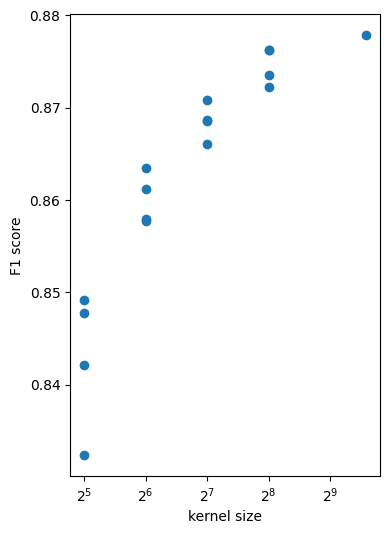

In [51]:
x = summary_df['n_components']
y = summary_df['f1-score']

plt.figure(figsize=(4,6))
plt.scatter(x,y)
plt.xscale('log',base=2)
# plt.yscale('log')
plt.ylabel('F1 score')
plt.xlabel('kernel size')
plt.show()

In [52]:
# Tabulate all the results as in CoNLL_2.ipynb
in_gold_test, not_in_gold_test = cleaning.flag_suspicious_labels(test_results,'ent_type','ent_type',gold_feats=test_gold,align_over_cols=['fold','doc_num','span'],keep_cols=[])

results_full_test=pd.concat([in_gold_test,not_in_gold_test]).sort_values(['fold','doc_num','span'])
results_full_test

,fold,doc_num,span,class,in_gold,count,models
0,test,0,"[19, 24): 'JAPAN'",LOC,True,2,"[GOLD, 128_4, 32_4]"
2,test,0,"[19, 24): 'JAPAN'",PER,False,13,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1,test,0,"[19, 24): 'JAPAN'",ORG,False,2,"[64_3, 32_3]"
3,test,0,"[29, 34): 'LUCKY'",LOC,False,13,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_3, 128..."
4,test,0,"[29, 34): 'LUCKY'",ORG,False,2,"[32_2, 32_3]"
...,...,...,...,...,...,...,...
8170,test,230,"[1213, 1225): 'Leeds United'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
8171,test,230,"[1252, 1259): 'England'",LOC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
8173,test,230,"[1341, 1355): '1966 World Cup'",MISC,True,0,[GOLD]
8172,test,230,"[1346, 1355): 'World Cup'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."


In [53]:
# How many results are in the gold standard?
in_gold_test

,fold,doc_num,span,class,in_gold,count,models
8173,test,230,"[1341, 1355): '1966 World Cup'",MISC,True,0,[GOLD]
8143,test,230,"[30, 38): 'CHARLTON'",PER,True,0,[GOLD]
8132,test,229,"[703, 711): 'Sporting'",ORG,True,0,[GOLD]
8097,test,228,"[771, 795): 'De Graafschap Doetinchem'",ORG,True,0,[GOLD]
8044,test,227,"[99, 105): 'Balkan'",LOC,True,0,[GOLD]
...,...,...,...,...,...,...,...
20,test,0,"[249, 254): 'China'",LOC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
17,test,0,"[196, 201): 'Syria'",LOC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
16,test,0,"[151, 160): 'Asian Cup'",MISC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
15,test,0,"[118, 123): 'Japan'",LOC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."


In [54]:
# How many entities were found by zero models?
in_gold_test[['count','fold']].groupby('count').count().rename(columns={'fold':'num_entities'})

,num_entities
count,
0,408
1,77
2,62
3,36
4,40
5,39
6,35
7,45
8,45


In [55]:
# How many non-results were found by many models?
not_in_gold_test[['count','fold']].groupby('count').count().rename(columns={'fold':'num_entities'})

,num_entities
count,
1,1029
2,361
3,215
4,146
5,98
6,86
7,62
8,55
9,54


In [56]:
# Hardest results from the gold standard to get.
# Use document ID to break ties.
hard_to_get_test = in_gold_test.sort_values(["count", "fold", "doc_num"],ascending=[True, True, True]).reset_index()
hard_to_get_test.head(20)

,index,fold,doc_num,span,class,in_gold,count,models
0,10,test,0,"[66, 77): 'Nadim Ladki'",PER,True,0,[GOLD]
1,86,test,1,"[686, 700): '1995 World Cup'",MISC,True,0,[GOLD]
2,68,test,1,"[42, 47): 'ITALY'",LOC,True,0,[GOLD]
3,121,test,2,"[35, 40): 'JAPAN'",LOC,True,0,[GOLD]
4,185,test,3,"[21, 37): 'SKIING-WORLD CUP'",MISC,True,0,[GOLD]
5,324,test,5,"[1042, 1050): 'N. Astle'",PER,True,0,[GOLD]
6,369,test,6,"[111, 114): 'Cup'",MISC,True,0,[GOLD]
7,366,test,6,"[88, 110): 'English F.A. Challenge'",MISC,True,0,[GOLD]
8,399,test,7,"[645, 654): 'Feyenoord'",ORG,True,0,[GOLD]
9,397,test,7,"[490, 497): 'Udinese'",ORG,True,0,[GOLD]


### Results from hand-labeling:

Document | Error Type | Corpus Span                | Tag      | Corrected Span | Tag       | Notes
---------|------------|----------------------------|----------|----------------|-----------|----------------------------------------------------------------
0        | None       | `[66, 77): 'Nadim Ladki'`  | `PER`    |                |           | 
0        | None       | `[78, 84): 'AL-AIN'`       | `LOC`    |
0        | None       | `[1824, 1831): 'Syrians'`  | `MISC`   |
1        | Tag        | `[42, 47): 'ITALY'`        | `LOC`    |                | `ORG`     | Italian World Cup team
1        | None       | `[686, 700): '1995 World Cup'` | `MISC`
3        | Span       | `[21, 37): 'SKIING-WORLD CUP'` | `MISC`| `[28, 37): 'WORLD CUP'` | | "FREESTYLE SKIING-WORLD CUP MOGUL RESULTS."
5        | Tag        | `[31, 42): 'NEW ZEALAND'`  | `LOC`    |                | `ORG`
5        | None       | `[223, 234): 'Saeed Anwar'`| `PER`
5        | None       | `[280, 286): 'Cairns'`     | `PER`
5        | None       | `[779, 785): 'Cairns'`     | `PER`
6        | Sentence   | `[88, 110): 'English F.A. Challenge'` | `MISC` | `[88, 114): 'English F.A. Challenge Cup'`
6        | Sentence   | `[111, 114): 'Cup'`        | `MISC`   | `[88, 114): 'English F.A. Challenge Cup'`
7        | None       | `[491, 498): 'Udinese'`    | `ORG`
7        | None       | `[646, 655): 'Feyenoord'`  | `ORG`
7        | Spelling   | `[772, 779): 'Engllsh'`    | `MISC`   | `[772, 779): 'English'`
8        | None       | `[26, 32): 'BOWYER'`       | `PER`
8        | None       | `[94, 101): 'England'`     | `LOC`
9        | None       | `[23, 33): 'EUROLEAGUE'`   | `MISC`



In [57]:
# Hardest results not in the gold standard to avoid
test_hard_to_avoid = (
    not_in_gold_test
    .sort_values(["count", "fold", "doc_num"], 
                 ascending=False)
    .head(20))
test_hard_to_avoid

,fold,doc_num,span,class,in_gold,count,models
8172,test,230,"[1346, 1355): 'World Cup'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
8131,test,229,"[703, 717): 'Sporting Gijon'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7987,test,224,"[166, 188): 'National Hockey League'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7977,test,223,"[288, 294): 'Ottawa'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7975,test,223,"[277, 285): 'EDMONTON'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7973,test,223,"[266, 274): 'COLORADO'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7971,test,223,"[255, 263): 'St Louis'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7969,test,223,"[246, 252): 'DALLAS'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7967,test,223,"[231, 243): 'Philadelphia'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7955,test,223,"[76, 98): 'National Hockey League'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."


### Results from hand-labeling the above 20 examples

Document | Error Type | Model Span                     | Tag      | Corpus Span                | Corpus Tag | Notes
---------|------------|--------------------------------|----------|----------------------------|------------|-----------------------------------------------------
229      | Span       | `[704, 718): 'Sporting Gijon'` | `LOC`    |`[704, 712): 'Sporting'`    | `ORG`      |
223      | Tag        | `[232, 244): 'Philadelphia'`   | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[247, 253): 'DALLAS'`         | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[256, 264): 'St Louis'`       | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[267, 275): 'COLORADO'`       | `ORG`    |                            | `LOC`      | Hockey team
223      | Tag        | `[289, 295): 'Ottawa'`         | `ORG`    |                            | `LOC`      | Hockey team
222      | Sentence   | `[93, 115): 'National Hockey League'` | `MISC` | `[93, 108): 'National Hockey'`
222      | Sentence   | `[93, 115): 'National Hockey League'` | `MISC` | `[109, 115): 'League'`
219      | Tag        | `[562, 565): 'UAE'`            | `ORG`    |                            | `LOC`      | Soccer team
213      | Sentence   | `[697, 708): 'Dion Fourie'`    | `PER`    | `[697, 701): 'Dion'`
213      | Sentence   | `[697, 708): 'Dion Fourie'`    | `PER`    | `[702, 708): 'Fourie'`
210      | None       | `[942, 944): 'Bo'`             | `ORG`    | `[942, 954): 'Boreham Wood'` |          | Split token
210      | None       | `[944, 954): 'reham Wood'`     | `ORG`    | `[942, 954): 'Boreham Wood'` |          | Split token
209      | Sentence   | `[384, 393): 'East Fife'`      | `ORG`    | `[384, 388): 'East'`
209      | Sentence   | `[384, 393): 'East Fife'`      | `ORG`    | `[389, 393): 'Fife'`
207      | None       | `[2726, 2728): 'Le'`           | `ORG`    | `[2726, 2739): 'Leyton Orient'` |       | Split token
207      | None       | `[2728, 2739): 'yton Orient'`  | `ORG`    | `[2726, 2739): 'Leyton Orient'` |       | Split token
205      | Tag        | `[627, 636): 'Wimbledon'`      | `ORG`    |                            | `LOC`      | Soccer team
202      | None       | `[150, 151): 'W'`              | `ORG`    | `[150, 156): 'Widnes'`     |            | Split token
202      | None       | `[151, 156): 'idnes'`          | `ORG`    | `[150, 156): 'Widnes'`     |            | Split token
200      | Sentence   | `[284, 295): 'Aston Villa'`    | `ORG`    | `[284, 289): 'Aston'`
200      | Sentence   | `[284, 295): 'Aston Villa'`    | `ORG`    | `[290, 295): 'Villa'`
200      | Tag        | `[337, 346): 'Wimbledon'`      | `ORG`    |                            | `LOC`      | Soccer team


## Use the same models to find incorrect labels in the development set

In [58]:
dev_df = corpus_df[corpus_df["fold"] == "dev"]
dev_gold = corpus_entities[corpus_entities.fold == 'dev']

dev_results = {
    name: cleaning.infer_and_extract_entities_iob(dev_df,corpus_raw, int_to_label,model)
    for name, model in models.items()
}
dev_results.keys()

dict_keys(['256_1', '256_2', '256_3', '256_4', '128_1', '128_2', '128_3', '128_4', '64_1', '64_2', '64_3', '64_4', '32_1', '32_2', '32_3', '32_4', '768_1'])

In [59]:
# Tabulate all the results as in CoNLL_2.ipynb
in_gold_dev, not_in_gold_dev = cleaning.flag_suspicious_labels(dev_results,'ent_type','ent_type',gold_feats=dev_gold,align_over_cols=['fold','doc_num','span'],keep_cols=[])
results_full_dev=pd.concat([in_gold_dev,not_in_gold_dev]).sort_values(['fold','doc_num','span'])
results_full_dev

,fold,doc_num,span,class,in_gold,count,models
2,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,True,0,[GOLD]
1,dev,0,"[20, 34): 'LEICESTERSHIRE'",MISC,False,9,"[256_3, 256_4, 128_2, 128_3, 128_4, 64_2, 64_3..."
3,dev,0,"[20, 34): 'LEICESTERSHIRE'",PER,False,4,"[256_1, 64_1, 32_1, 32_2]"
0,dev,0,"[20, 34): 'LEICESTERSHIRE'",LOC,False,1,[32_3]
4,dev,0,"[40, 44): 'OVER'",MISC,False,1,[32_4]
...,...,...,...,...,...,...,...
7798,dev,215,"[633, 649): 'Bangladesh Lamps'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
7799,dev,215,"[651, 668): 'Chittagong Cement'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
7800,dev,215,"[673, 689): 'Atlas Bangladesh'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
7801,dev,215,"[849, 852): 'DSE'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."


In [60]:
(in_gold_dev[["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_entities"}))

,num_entities
count,
0,206
1,59
2,44
3,42
4,37
5,32
6,29
7,41
8,41


In [61]:
(not_in_gold_dev[["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_entities"}))

,num_entities
count,
1,788
2,265
3,167
4,127
5,72
6,51
7,45
8,43
9,33


In [62]:
hard_to_get_dev = results_full_dev[results_full_dev.in_gold].sort_values(["count", "fold", "doc_num"],ascending=[True, True, True]).reset_index(drop=True)
hard_to_get_dev.head(20)

,fold,doc_num,span,class,in_gold,count,models
0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,True,0,[GOLD]
1,dev,0,"[2225, 2235): 'ex-England'",MISC,True,0,[GOLD]
2,dev,2,"[25, 30): 'ASHES'",MISC,True,0,[GOLD]
3,dev,2,"[87, 92): 'Ashes'",MISC,True,0,[GOLD]
4,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,True,0,[GOLD]
5,dev,6,"[19, 24): 'ROTOR'",ORG,True,0,[GOLD]
6,dev,6,"[262, 267): 'Rotor'",ORG,True,0,[GOLD]
7,dev,6,"[399, 404): 'Rotor'",ORG,True,0,[GOLD]
8,dev,7,"[993, 1003): 'Panamanian'",MISC,True,0,[GOLD]
9,dev,7,"[1004, 1022): 'Boxing Association'",ORG,True,0,[GOLD]


### Results from hand-labeling the above 20 examles:

#### TODO: Update this cell with table from CSV file

In [63]:
# Hardest results from the gold standard to avoid
dev_hard_to_avoid = results_full_dev[~results_full_dev.in_gold].sort_values(
    ["count", "fold", "doc_num"], ascending=False).head(20)
dev_hard_to_avoid

,fold,doc_num,span,class,in_gold,count,models
7714,dev,214,"[187, 202): 'Michael Collins'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7546,dev,206,"[2472, 2483): 'Carl Vinson'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7326,dev,199,"[106, 122): 'Turkish-operated'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7306,dev,198,"[39, 47): 'aid-U.N.'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7283,dev,197,"[500, 507): 'Lebanon'",LOC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
7116,dev,191,"[1031, 1041): 'Korean War'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
6918,dev,185,"[54, 62): 'SANTIAGO'",LOC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
6904,dev,184,"[789, 795): 'Granma'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
6626,dev,178,"[11, 32): 'S. African Afrikaners'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
6652,dev,178,"[1513, 1522): 'Coloureds'",MISC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."


### Results from hand-labeling the above 20 examles:

#### TODO: Update this cell with table from CSV file

## Also look for incorrect labels on the training set

Apply the same process to the training set to see what we get. Since these
models are trained on this set, we don't expect their aggregate results to
flag many incorrect labels. Generate the data anyhow just to see what happens.

In [64]:
train_df = corpus_df[corpus_df["fold"] == "train"]
train_gold = corpus_entities[corpus_entities.fold == 'train']

train_results = {
    name: cleaning.infer_and_extract_entities_iob(train_df,corpus_raw, int_to_label,model)
    for name, model in models.items()
}
train_results.keys()

dict_keys(['256_1', '256_2', '256_3', '256_4', '128_1', '128_2', '128_3', '128_4', '64_1', '64_2', '64_3', '64_4', '32_1', '32_2', '32_3', '32_4', '768_1'])

In [65]:
# Tabulate all the results as in CoNLL_2.ipynb
in_gold_train, not_in_gold_train= cleaning.flag_suspicious_labels(train_results,'ent_type','ent_type',gold_feats=train_gold,align_over_cols=['fold','doc_num','span'],keep_cols=[])
results_full_train=pd.concat([in_gold_train,not_in_gold_train]).sort_values(['fold','doc_num','span'])
results_full_train

,fold,doc_num,span,class,in_gold,count,models
0,train,0,"[11, 13): 'EU'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
1,train,0,"[22, 28): 'German'",MISC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
2,train,0,"[45, 52): 'British'",MISC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
3,train,0,"[59, 74): 'Peter Blackburn'",PER,True,2,"[GOLD, 32_3, 768_1]"
5,train,0,"[59, 83): 'Peter Blackburn BRUSSELS'",PER,False,15,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
...,...,...,...,...,...,...,...
28020,train,945,"[72, 79): 'English'",MISC,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
28021,train,945,"[119, 127): 'Plymouth'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
28022,train,945,"[130, 137): 'Preston'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."
28023,train,945,"[155, 162): 'Swansea'",ORG,True,17,"[GOLD, 256_1, 256_2, 256_3, 256_4, 128_1, 128_..."


In [66]:
(in_gold_train[["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_ents"}))

,num_ents
count,
0,286
1,131
2,113
3,109
4,83
5,90
6,96
7,141
8,137


In [67]:
(not_in_gold_train[["count", "span"]]
 .groupby("count").count()
 .rename(columns={"span": "num_ents"}))

,num_ents
count,
1,2170
2,720
3,411
4,253
5,182
6,122
7,98
8,72
9,66


In [68]:
train_hard_to_get = in_gold_train.sort_values(["count", "fold", "doc_num"]).head(20)
train_hard_to_get

,fold,doc_num,span,class,in_gold,count,models
142,train,6,"[121, 137): 'Toronto Dominion'",PER,True,0,[GOLD]
610,train,24,"[161, 169): 'Africans'",MISC,True,0,[GOLD]
628,train,25,"[141, 151): 'mid-Norway'",MISC,True,0,[GOLD]
757,train,29,"[894, 902): 'Maruyama'",PER,True,0,[GOLD]
755,train,29,"[886, 893): 'Shigeki'",PER,True,0,[GOLD]
746,train,29,"[767, 774): 'O'Meara'",PER,True,0,[GOLD]
745,train,29,"[762, 766): 'Mark'",PER,True,0,[GOLD]
720,train,29,"[459, 468): 'Mickelson'",PER,True,0,[GOLD]
719,train,29,"[454, 458): 'Phil'",PER,True,0,[GOLD]
793,train,31,"[63, 71): 'PRESCOTT'",PER,True,0,[GOLD]


In [69]:
# Hardest results from the gold standard to avoid
train_hard_to_avoid = not_in_gold_train.sort_values(
    ["count", "fold", "doc_num"], ascending=[False,True,True]).head(20)
train_hard_to_avoid

,fold,doc_num,span,class,in_gold,count,models
141,train,6,"[121, 137): 'Toronto Dominion'",LOC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
627,train,25,"[141, 151): 'mid-Norway'",LOC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
756,train,29,"[886, 902): 'Shigeki Maruyama'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
744,train,29,"[762, 774): 'Mark O'Meara'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
718,train,29,"[454, 468): 'Phil Mickelson'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1016,train,37,"[837, 846): 'Moin Khan'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1086,train,41,"[364, 378): 'Czech Republic'",LOC,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1301,train,43,"[2668, 2690): 'Constructorul Chisinau'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1279,train,43,"[2364, 2376): 'Petr Gabriel'",PER,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."
1267,train,43,"[2104, 2117): 'Dynamo Batumi'",ORG,False,17,"[256_1, 256_2, 256_3, 256_4, 128_1, 128_2, 128..."


# Write CSV files for manual labeling

Generate CSV outputs like the ones from `CoNLL_2.ipynb` so that we can 
manually label the examples our ensemble flagged in the development test sets.

In [70]:
# First pair of files contains the outputs for the dev and test
# sets, as in the output of CoNLL_2.ipynb
dev_and_test_results = pd.concat([results_full_dev, results_full_test])
in_gold_to_write, not_in_gold_to_write = cleaning.analysis.csv_prep(dev_and_test_results, "count",ent_type_col_name = 'class')
in_gold_to_write

,count,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
2,0,dev,0,"[20, 34): 'LEICESTERSHIRE'",ORG,,,,,,,
54,0,dev,0,"[2225, 2235): 'ex-England'",MISC,,,,,,,
121,0,dev,2,"[25, 30): 'ASHES'",MISC,,,,,,,
125,0,dev,2,"[87, 92): 'Ashes'",MISC,,,,,,,
143,0,dev,2,"[614, 634): 'Duke of Norfolk's XI'",ORG,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
8167,17,test,230,"[1108, 1115): 'Germany'",LOC,,,,,,,
8169,17,test,230,"[1153, 1160): 'England'",LOC,,,,,,,
8170,17,test,230,"[1213, 1225): 'Leeds United'",ORG,,,,,,,
8171,17,test,230,"[1252, 1259): 'England'",LOC,,,,,,,


In [71]:
not_in_gold_to_write

,count,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
53,17,dev,0,"[2225, 2235): 'ex-England'",LOC,,,,,,,,,
256,17,dev,6,"[262, 267): 'Rotor'",PER,,,,,,,,,
261,17,dev,6,"[399, 404): 'Rotor'",PER,,,,,,,,,
479,17,dev,11,"[1961, 1975): 'Czech Republic'",LOC,,,,,,,,,
625,17,dev,13,"[83, 104): 'Major League Baseball'",MISC,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8110,1,test,229,"[19, 26): 'SPANISH'",LOC,,,,,,,,,
8139,1,test,230,"[19, 29): 'ENGLISHMAN'",LOC,,,,,,,,,
8141,1,test,230,"[19, 29): 'ENGLISHMAN'",ORG,,,,,,,,,
8142,1,test,230,"[19, 29): 'ENGLISHMAN'",PER,,,,,,,,,


In [72]:
# Write the CSV file for test and validation results
in_gold_to_write.to_csv("outputs/CoNLL_3_in_gold.csv", index=False)
not_in_gold_to_write.to_csv("outputs/CoNLL_3_not_in_gold.csv", index=False)

In [73]:
# Generate a second pair of dataframes with results on the training set
train_in_gold, train_not_in_gold = cleaning.analysis.csv_prep(results_full_train,  "count",ent_type_col_name = 'class')
train_in_gold

,count,fold,doc_offset,corpus_span,corpus_ent_type,error_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
142,0,train,6,"[121, 137): 'Toronto Dominion'",PER,,,,,,,
610,0,train,24,"[161, 169): 'Africans'",MISC,,,,,,,
628,0,train,25,"[141, 151): 'mid-Norway'",MISC,,,,,,,
719,0,train,29,"[454, 458): 'Phil'",PER,,,,,,,
720,0,train,29,"[459, 468): 'Mickelson'",PER,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...
28020,17,train,945,"[72, 79): 'English'",MISC,,,,,,,
28021,17,train,945,"[119, 127): 'Plymouth'",ORG,,,,,,,
28022,17,train,945,"[130, 137): 'Preston'",ORG,,,,,,,
28023,17,train,945,"[155, 162): 'Swansea'",ORG,,,,,,,


In [74]:
train_not_in_gold

,count,fold,doc_offset,model_span,model_ent_type,error_type,corpus_span,corpus_ent_type,correct_span,correct_ent_type,notes,time_started,time_stopped,time_elapsed
141,17,train,6,"[121, 137): 'Toronto Dominion'",LOC,,,,,,,,,
627,17,train,25,"[141, 151): 'mid-Norway'",LOC,,,,,,,,,
718,17,train,29,"[454, 468): 'Phil Mickelson'",PER,,,,,,,,,
744,17,train,29,"[762, 774): 'Mark O'Meara'",PER,,,,,,,,,
756,17,train,29,"[886, 902): 'Shigeki Maruyama'",PER,,,,,,,,,
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
27919,1,train,943,"[159, 164): 'Grand'",MISC,,,,,,,,,
27921,1,train,943,"[165, 169): 'Prix'",MISC,,,,,,,,,
27952,1,train,944,"[11, 15): 'GOLF'",LOC,,,,,,,,,
27958,1,train,944,"[33, 38): 'THIRD'",MISC,,,,,,,,,


In [75]:
# Write the training set information to a second pair of CSV files
train_in_gold.to_csv("outputs/CoNLL_3_train_in_gold.csv", index=False)
train_not_in_gold.to_csv("outputs/CoNLL_3_train_not_in_gold.csv", index=False)